In [55]:
import rerun as rr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
%matplotlib inline

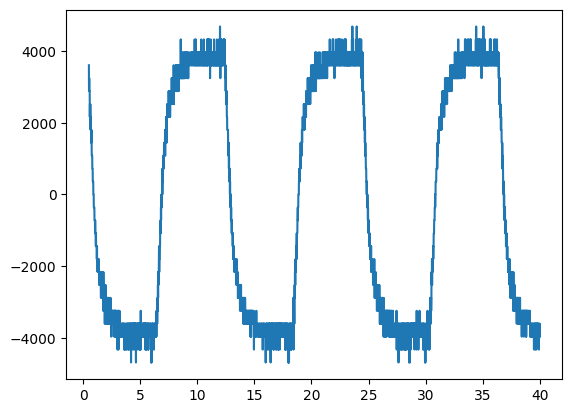

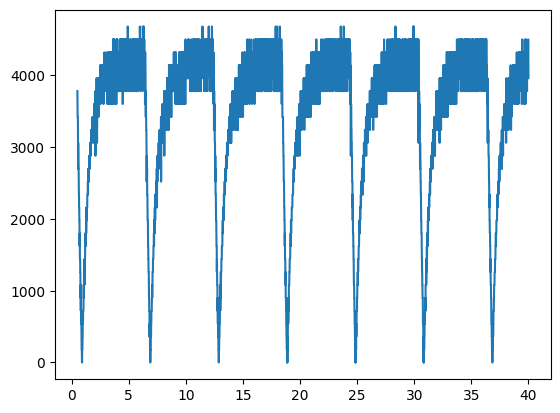

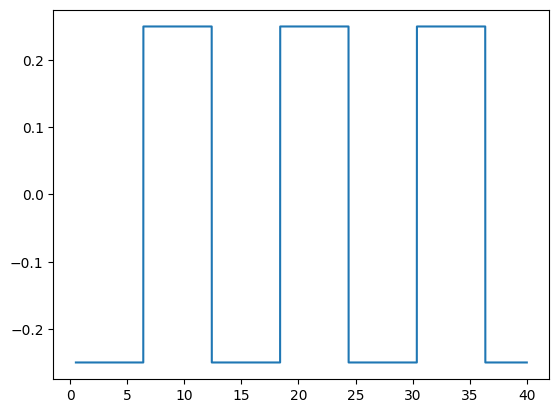

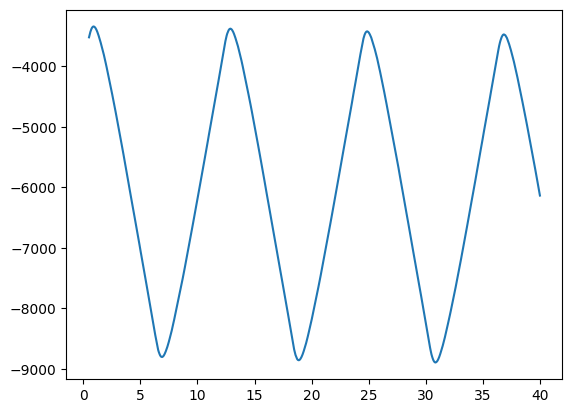

In [56]:

path_to_rrd = "./changing_sign.rrd"
recording = rr.dataframe.load_recording(path_to_rrd)
batches = recording.view(index="sample_time", contents="/**").select()
df: pd.DataFrame = batches.read_pandas()

Fs = 100
Ts = 1/Fs
df = df[df['sample_time'] > pd.to_timedelta(0.5*1e9)]
df = df[df['sample_time'] < pd.to_timedelta(40*1e9)]
ts = df['sample_time'].to_numpy().astype(np.float64) / 1e9
velocity = np.concatenate(df['/velocity:Scalar'].to_numpy())
abs_velocity = np.concatenate(df['/abs_velocity:Scalar'].to_numpy())
control = np.concatenate(df['/control:Scalar'].to_numpy())
ticks = np.concatenate(df['/ticks:Scalar'].to_numpy())

plt.figure(1)
plt.plot(ts, velocity)
plt.figure(2)
plt.plot(ts, abs_velocity)
plt.figure(3)
plt.plot(ts, control)
plt.figure(4)
plt.plot(ts, ticks)

[[ 0.  ]
 [-0.25]]
[[2344.03823206]
 [  11.06775994]]
[[-1313.66983929]
 [  -39.18584178]]
[[1665.80264072]
 [  29.34274461]]
[[-1522.48373023]
 [  -73.51527436]]
[[1571.61692051]
 [  54.03046176]]
[[-1548.06462964]
 [ -101.88000617]]
[[1552.08007965]
 [  79.39601414]]
[[-1547.08233112]
 [ -127.45717183]]
[[1544.63437511]
 [ 103.75248091]]
[[-1541.48235384]
 [ -151.15637061]]
[[1538.94123785]
 [ 126.68617397]]
[[-1535.81824366]
 [ -173.33761985]]
[[1533.25973749]
 [ 148.15608165]]
[[-1530.75552574]
 [ -194.14863403]]
[[1528.57323133]
 [ 168.35741937]]
[[-1525.91938214]
 [ -213.64385577]]
[[1523.17021784]
 [ 187.17047627]]
[[-1521.34575046]
 [ -231.89899061]]
[[1518.89317233]
 [ 204.90718985]]
[[-1516.95005422]
 [ -248.98514877]]
[[1515.15660101]
 [ 221.57460949]]
[[-1512.9566455 ]
 [ -265.01096844]]
[[1511.25681214]
 [ 237.13498525]]
[[-1509.63495965]
 [ -280.0917025 ]]
[[1508.32882924]
 [ 251.84669374]]
[[-1507.17079497]
 [ -294.3410733 ]]
[[1505.68365962]
 [ 265.66563306]]
[[-1504.59

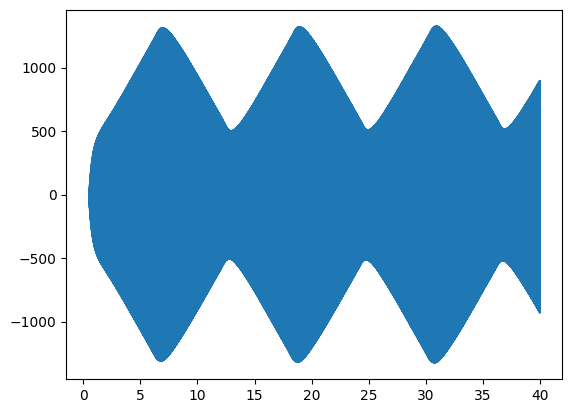

In [ ]:

class EKF:
    def __init__(self, A, B, C, Q, R, x0=None, P0=None):
        self.A = A
        self.B = B
        self.C = C
        self.Q = Q
        self.R = R
        self.x = x0 or np.zeros((A.shape[0], 1))
        self.P = P0 or np.zeros((A.shape[0], A.shape[1]))
    
    def h(self, x: np.ndarray) -> np.ndarray:
        # return self.C
        return np.abs(self.C @ x)

    def grad_h(self, x: np.ndarray) -> np.ndarray:
        # return self.C
        return self.C * np.sign(self.C @ x)

    def step(self, meas, u) -> np.ndarray:
        self.x = self.A @ self.x + self.B * u
        self.P = self.Q  + self.A @ self.P @ self.A.T

        hprim = self.grad_h(self.x)
        
        S = self.R + hprim @ self.P @ hprim.T
        error = meas - self.h(self.x)
        
        K = self.P @ hprim.T @ np.linalg.inv(S)

        self.P = self.P - self.P @ hprim.T @ np.linalg.inv(S) @ hprim @ self.P
        self.x = self.x + K @ error

        return self.x

# ss = ct.tf2ss(modeld)
A = np.array([[1, Ts], [0, 0.98676]])
B = np.array([[0.0], [1.0]])
C = np.array([[1.0, 0.0]])
ekf = EKF(A, B, C, 1*np.eye(2), 1*np.eye(1))

out = []
us = control.reshape((-1,1))
ys = ticks.reshape((-1,1))
#ys = abs_velocity.reshape((-1,1))

for i in range(len(ys)):
    y = ys[i:i+1,:]
    u = us[i,:]
    xhat = ekf.step(y, u)
    print(xhat)
    out.append(xhat[1,0])
    # u = signal[i:i+1,:]
    pass

conout = np.array(out)
plt.plot(ts[:len(conout)], conout)

Fs=100


In [40]:
out

[array([[0.]]),
 array([[125.55541661]]),
 array([[407.06528769]]),
 array([[905.24079859]]),
 array([[1679.19305298]]),
 array([[2786.01209144]]),
 array([[4280.39362615]]),
 array([[6214.27923985]]),
 array([[8636.56191574]]),
 array([[11592.80530341]]),
 array([[15125.03127304]]),
 array([[19271.55900868]]),
 array([[24066.85877495]]),
 array([[29541.49659821]]),
 array([[35722.07652882]]),
 array([[42631.27695257]]),
 array([[50287.8724235]]),
 array([[58706.84969359]]),
 array([[67899.49537618]]),
 array([[77873.5759874]]),
 array([[88633.47498228]]),
 array([[100180.40034205]]),
 array([[112512.61068505]]),
 array([[125625.59438102]]),
 array([[139512.33416612]]),
 array([[154163.49479424]]),
 array([[169567.69434583]]),
 array([[185711.68759124]]),
 array([[202580.63224852]]),
 array([[220158.25817565]]),
 array([[238427.09586447]]),
 array([[257368.69664068]]),
 array([[276963.76853736]]),
 array([[297192.39801031]]),
 array([[318034.15941628]]),
 array([[339468.31306685]]),
 a